# Importing Libraries

In [1]:
import rlcompleter

In [2]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
torch.manual_seed(0)
print('Using Pytorch version', torch.__version__)

Using Pytorch version 1.7.1


RANDOMLY SELECTING IMAGES FROM DATA TO CREATE A TEST SET OF IMAGES

# Preparing Training and Test Sets

In [3]:
pwd

'C:\\Users\\bhandm\\Desktop\\CODING_PROJECTS\\CODING_PROJECTS\\COVID'

In [4]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/Users/deepbhandari/Desktop/COVID_PROJECT/COVID-19 Radiography Database'
source_dirs = ['normal', 'viral', 'covid']
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
        
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        
    for image in selected_images:
        source_path = os.path.join(root_dir, image)
        target_path = os.path.join(root_dir, 'test', image)
        shutil.move(source_path, target_path)

FileExistsError: [Errno 17] File exists: '/Users/deepbhandari/Desktop/COVID_PROJECT/COVID-19 Radiography Database/test'

#unsure why this didn't work for normal and viral so have had to do it 'manually' as below

In [7]:
images = [x for x in os.listdir(os.path.join(root_dir, 'viral' )) if x.lower().endswith('png')]
selected_images = random.sample(images, 30)

In [6]:
'''shows that you need the for loop otherwise image is stuck as the last one from runnign the above block'''
source_path

NameError: name 'source_path' is not defined

In [8]:
  for image in selected_images:
    source_path = os.path.join(root_dir, 'viral', image)
    target_path = os.path.join(root_dir, 'test', 'viral', image)
    shutil.move(source_path, target_path)

In [9]:
images = [x for x in os.listdir(os.path.join(root_dir, 'normal' )) if x.lower().endswith('png')]
selected_images = random.sample(images, 30)

In [10]:
 for image in selected_images:
    source_path = os.path.join(root_dir, 'normal', image)
    target_path = os.path.join(root_dir, 'test', 'normal', image)
    shutil.move(source_path, target_path)

defining an intializer function where we pass image directories of the three classes and a transform object 
transform is to convert the images into tensors nad data augmentation before it passes into the model
'class_name' will be either covid, normal or pneumonia
'get_images' will make a list of the images of whichever class
the print function then prints the number of images in 'images' and which class it

# Creating Custom Dataset

In [11]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name= self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [12]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [13]:
train_dirs = {
    'normal': f'{root_dir}/normal',
    'viral': f'{root_dir}/viral',
    'covid': f'{root_dir}/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1251 normal examples
Found 1255 viral examples
Found 941 covid examples


In [14]:
test_dirs = {
    'normal': f'{root_dir}/test/normal',
    'viral': f'{root_dir}/test/viral',
    'covid': f'{root_dir}/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 90 normal examples
Found 90 viral examples
Found 30 covid examples


In [15]:
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)

SyntaxError: invalid syntax (<ipython-input-15-26827bfb4abd>, line 4)

In [16]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 575
Number of test batches 35


# Data Visualization

In [17]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

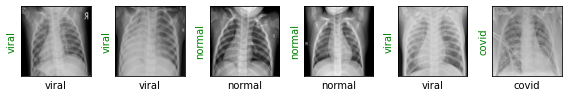

In [18]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

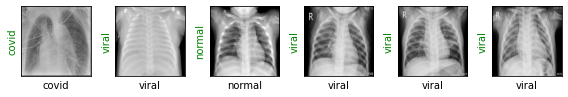

In [20]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [21]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [23]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

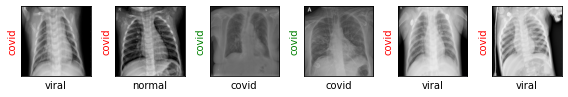

In [24]:
show_preds()

# Training the Model

In [25]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.4172, Accuracy: 0.3571


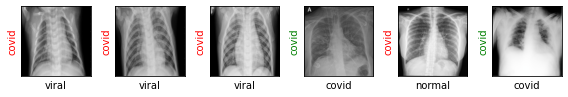

Evaluating at step 20
Validation Loss: 0.7049, Accuracy: 0.7571


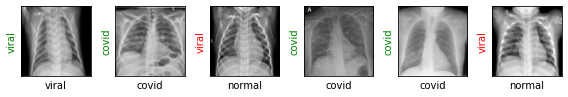

Evaluating at step 40
Validation Loss: 0.4301, Accuracy: 0.8857


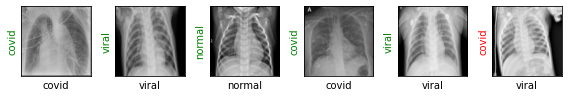

Evaluating at step 60
Validation Loss: 0.1793, Accuracy: 0.9429


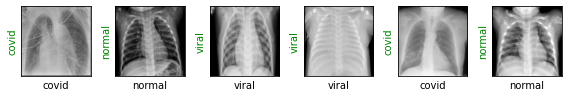

Evaluating at step 80
Validation Loss: 0.1480, Accuracy: 0.9429


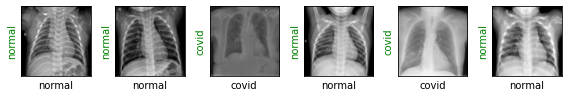

Evaluating at step 100
Validation Loss: 0.1723, Accuracy: 0.9524


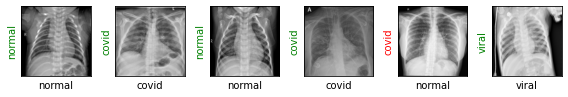

Performance condition satisfied, stopping..
CPU times: user 4min 11s, sys: 45.2 s, total: 4min 56s
Wall time: 4min 54s


In [26]:
%%time

train(epochs=1)

# Final Results

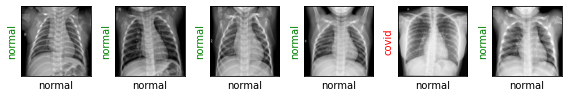

In [27]:
show_preds()

END

In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(list(test_dataset), batch_size=batch_size, shuffle=True)

print('Number of training batches', len(list(dl_train)))
print('Number of test batches', len(list(dl_test)))

## 

In [103]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

In [ ]:
# Datasets
train_dataset = list(ChestXRayDataset(train_dirs, train_transform))

#training_set = Dataset(train_dataset)
training_generator = torch.utils.data.DataLoader(train_dataset, **params)
print('Number of training batches', len(training_generator))

In [76]:
torch.__version__

'1.7.1'

In [77]:
self = list(self)
random.shuffle(self)

NameError: name 'self' is not defined

In [15]:
conda -V

conda 4.9.2

Note: you may need to restart the kernel to use updated packages.


In [6]:
conda install -c anaconda cudatoolkit

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - cudatoolkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         127 KB  anaconda
    cudatoolkit-9.0            |       h41a26b3_0       281.1 MB  anaconda
    openssl-1.1.1h             |       haf1e3a3_0         3.4 MB  anaconda
    ------------------------------------------------------------
                                           Total:       284.7 MB

The following NEW packages will be INSTALLED:

  cudatoolkit        anaconda/osx-64::cudatoolkit-9.0-h41a26b3_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                 pkgs/main --> anaconda
  openssl                                         pkgs/main --> anaconda



cudatoolkit-9.0      | 281.1 MB  

In [7]:
conda install pytorch torchvision torchaudio -c pytorch

Solving environment: / 
  - anaconda/osx-64::ca-certificates-2020.10.14-0, anaconda/osx-64::openssl-1.1.1h-haf1e3a3_0
  - anaconda/osx-64::openssl-1.1.1h-haf1e3a3_0, defaults/osx-64::ca-certificates-2020.10.14-0
  - anaconda/osx-64::ca-certificates-2020.10.14-0, defaults/osx-64::openssl-1.1.1h-haf1e3a3_0
  - defaults/osx-64::ca-certificates-2020.10.14-0, defaults/osx-64::openssl-1.1.1h-haf1e3a3done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libuv-1.40.0               |       haf1e3a3_0         334 KB
    ninja-1.10.2               |   py38hf7b0b51_0         101 KB
    pytorch-1.7.1              |          py3.8_0        64.5 MB  pytorch
    torchaudio-0.7.2           |             py38         4.0 MB  pytorch
    torchvision-0.8.2          |       